In [1]:
# 单元格 1: 环境准备与核心函数定义

# 导入所有需要的库
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pycountry

# --- 核心函数定义 ---

def execute_query(db_path, query):
    """
    功能：连接指定的SQLite数据库，执行一条SQL查询语句。
    参数：
        db_path (str): 数据库文件的路径。
        query (str): 需要执行的SQL查询字符串。
    返回：
        pandas.DataFrame: 包含查询结果的DataFrame。如果出错则返回None。
    """
    try:
        with sqlite3.connect(db_path) as conn:
            df = pd.read_sql_query(query, conn)
            return df
    except Exception as e:
        print(f"执行查询时发生错误: {e}")
        return None

def get_iso_alpha_3(country_name):
    """
    功能：将国家/地区名称转换为标准的ISO 3166-1 alpha-3三字符代码。
    说明：内置了一个手动映射表来处理数据库中的非标准名称。
    参数：
        country_name (str): 数据库中的国家/地区名称。
    返回：
        str: 对应的三字符ISO代码，如果找不到则返回None。
    """
    # 手动映射表，处理 'pycountry' 无法直接识别的特殊名称
    manual_map = {
        'CHINA MAINLAND': 'CHN',
        'USA': 'USA',
        'ENGLAND': 'GBR',       # 英格兰、苏格兰等均属于联合王国 (GBR)
        'SCOTLAND': 'GBR',
        'WALES': 'GBR',
        'NORTH IRELAND': 'GBR',
        'GERMANY (FED REP GER)': 'DEU',
        'SOUTH KOREA': 'KOR',
        'RUSSIA': 'RUS',
        'IRAN': 'IRN'
    }
    
    if country_name in manual_map:
        return manual_map[country_name]
    
    try:
        # 尝试使用pycountry的模糊搜索功能来查找匹配项
        return pycountry.countries.search_fuzzy(country_name)[0].alpha_3
    except (LookupError, AttributeError):
        # 如果找不到任何匹配，则返回None
        return None

# --- 全局设置 ---
# 定义数据库文件路径，后续所有单元格都将使用此变量
DATABASE_FILE = 'esi_rankings.db'
print("✅ 环境准备就绪，核心函数已定义。")

✅ 环境准备就绪，核心函数已定义。


正在从数据库中查询指定大学的排名数据...
数据获取完毕，正在生成可视化图表...


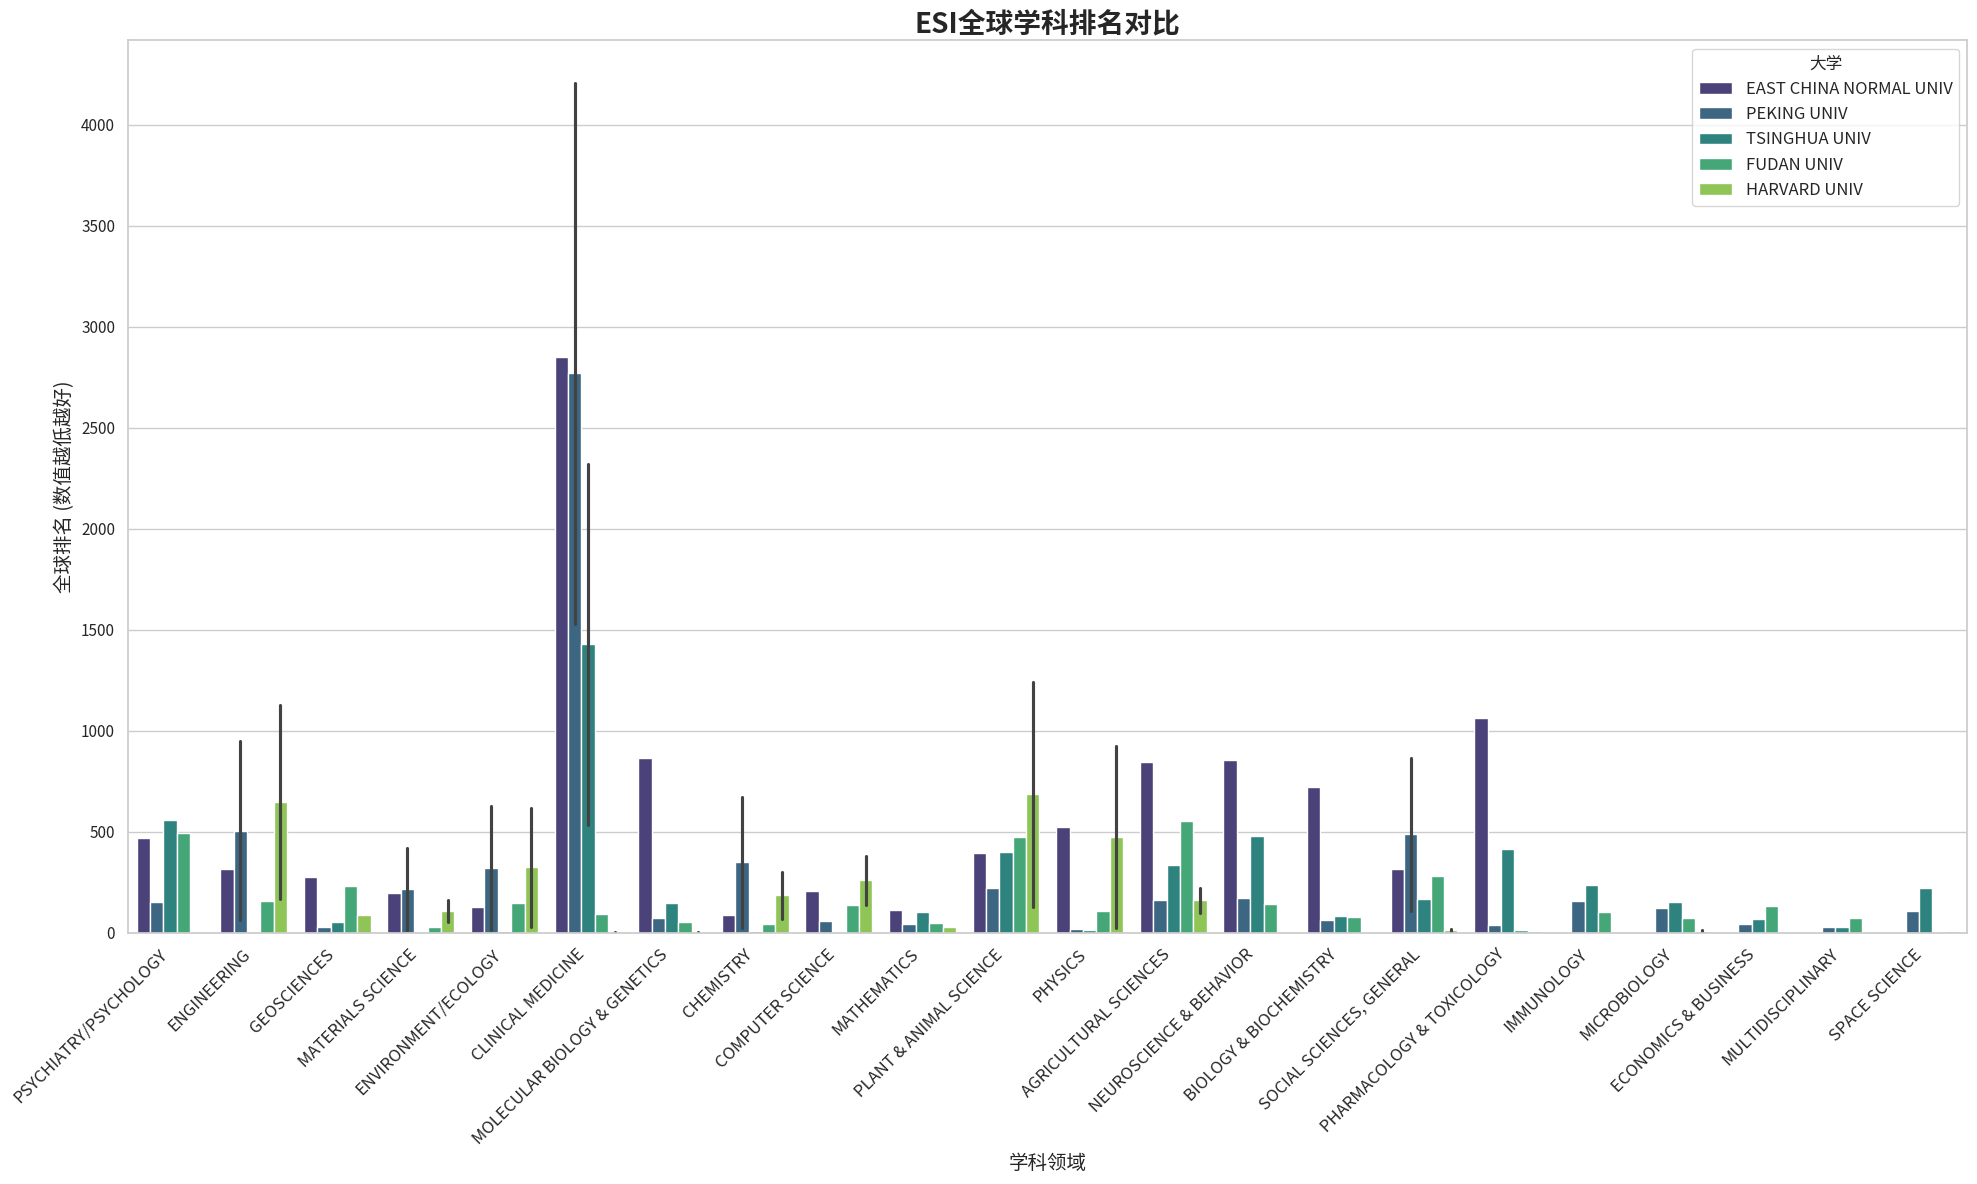

In [4]:
# 单元格 2: 分析任务一 - 对比多所大学的学科排名

# --- 1. 定义需要对比的大学列表 ---
universities_to_compare = [
    "EAST CHINA NORMAL UNIV",
    "PEKING UNIV",
    "TSINGHUA UNIV",
    "FUDAN UNIV",
    "HARVARD UNIV",
    "UNIV OXFORD"
]

# --- 2. 从数据库中获取数据 ---
all_rankings_data = []
print("正在从数据库中查询指定大学的排名数据...")

for university in universities_to_compare:
    # 使用参数化查询来安全地获取数据
    query = f"SELECT research_field, rank FROM esi_rankings WHERE institution LIKE '%{university}%'"
    df = execute_query(DATABASE_FILE, query)
    if df is not None and not df.empty:
        df['institution'] = university  # 添加大学名称列用于分组
        all_rankings_data.append(df)

# --- 3. 数据整合与可视化 ---
if all_rankings_data:
    # 将所有查询结果合并成一个DataFrame
    comparison_df = pd.concat(all_rankings_data, ignore_index=True)
    print("数据获取完毕，正在生成可视化图表...")

    # 使用Seaborn绘制分组条形图
    plt.figure(figsize=(20, 12))
    sns.set_theme(style="whitegrid", font='Source Han Sans SC') # 设置支持中文的字体，如黑体
    plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

    sns.barplot(
        data=comparison_df, 
        x='research_field', 
        y='rank', 
        hue='institution',
        palette='viridis'
    )

    # 美化图表
    plt.title('ESI全球学科排名对比', fontsize=20, weight='bold')
    plt.xlabel('学科领域', fontsize=14)
    plt.ylabel('全球排名 (数值越低越好)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.legend(title='大学', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("未能查询到任何指定大学的数据。")

In [11]:
# 单元格 3: 分析任务二 - 全球各学科表现的交互式世界地图

# --- 1. 从数据库获取按学科和国家分组的数据 ---
print("正在获取全球各学科数据用于生成世界地图...")
subject_data_query = """
    SELECT
      country_region,
      research_field,
      SUM(cites) AS total_cites
    FROM
      esi_rankings
    GROUP BY
      country_region, research_field;
"""
df_map = execute_query(DATABASE_FILE, subject_data_query)

# --- 2. 数据清洗和预处理 ---
if df_map is not None:
    print("数据预处理中：清洗、转换ISO代码...")
    df_map.dropna(subset=['country_region', 'research_field'], inplace=True)
    df_map['total_cites'] = pd.to_numeric(df_map['total_cites'], errors='coerce').fillna(0)
    df_map['iso_alpha'] = df_map['country_region'].apply(get_iso_alpha_3) # 调用单元格1的函数
    
    subjects = sorted(df_map['research_field'].unique())
    
    # --- 3. 创建带有下拉菜单的交互式地图 ---
    print("正在生成交互式地图...")
    fig = go.Figure()

    for subject in subjects:
        subject_df = df_map[df_map['research_field'] == subject]
        log_cites = np.log10(subject_df['total_cites'] + 1) # 对引用数取对数，以优化颜色显示

        fig.add_trace(
            go.Choropleth(
                locations=subject_df['iso_alpha'],
                z=log_cites,
                text=subject_df['country_region'],
                customdata=subject_df['total_cites'],
                hovertemplate='<b>%{text}</b><br>总引用数: %{customdata:,.0f}<extra></extra>',
                colorscale='Plasma',
                visible=(subject == subjects[0]) # 默认只显示第一个学科
            )
        )

    # --- 4. 配置下拉菜单和图表布局 ---
    buttons = []
    for i, subject in enumerate(subjects):
        visibility_mask = [False] * len(subjects)
        visibility_mask[i] = True
        buttons.append(dict(label=subject, method='update', args=[{'visible': visibility_mask}]))

    # 使用 update_layout 对图表布局进行精细调整
    fig.update_layout(
        title_text=f'<b>全球各学科学术影响力地图</b><br><i>请从下拉菜单中选择一个学科</i>',
        title_x=0.5,  # 将主标题居中显示
        title_font_size=22,
        
        # --- ↓↓↓ 这里是关键修改 ↓↓↓ ---
        margin=dict(t=70, l=0, r=0, b=0), # 增加顶部留白(margin-top)为150像素，为标题和菜单提供空间
        
        updatemenus=[dict(
            active=0,
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,           # 将菜单的x坐标设置在左侧10%的位置
            xanchor="left",  # x坐标的锚点是菜单的左边缘
            y=1.1,           # 将菜单的y坐标放在新的顶部空间内
            yanchor="top"    # y坐标的锚点是菜单的上边缘
        )],
        # --- ↑↑↑ 修改结束 ↑↑↑ ---
        
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='natural earth'
        )
    )

    fig.show()
else:
    print("未能获取用于生成地图的数据。")

正在获取全球各学科数据用于生成世界地图...
数据预处理中：清洗、转换ISO代码...
正在生成交互式地图...
